In [1]:
import matplotlib.pyplot as plt
import webbpsf
import os
import numpy as np
from astropy.io import fits
import scipy.ndimage as nd
from astropy.table import Table
import h5py
import math
from scipy.spatial import cKDTree
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs.utils import pixel_to_skycoord
from astropy.wcs import WCS
from numpy.random import uniform
import random


from utils import create_edge_mask
from extraction.SExtractor_pipeline import SExtractor
os.environ['WEBBPSF_PATH'] = "/Users/jt458/jwst_data/webbpsf-data"

In [ ]:
def find_matches(small_cat, large_cat):
    """
    Return indicies into a larger catalogue from X-Y matches to a smaller
    catalogue. Matches are not unique.
    
    Arguments
    ---------
    small_cat (numpy.ndarray)
        The X-Y coordinates of sources in the smaller catalogue.
    large_cat (numpy.ndarray)
        The X-Y coordinates of sources in the larger catalogue.
        
    Returns
    -------
    indices (List[int])
        For each object in small_cat, the index of the closest match in 
        large_cat.
    distances (List[float])
        The distance between matches in pixels."""

    # Create KD-tree for the larger catalogue
    large_tree = cKDTree(large_cat)
    
    # Query the KD-tree with the positions from the smaller catalogue
    distances, indices = large_tree.query(small_cat)

    # Sort indices and reorder distances accordingly
    sorted_indices = np.argsort(indices)
    indices = indices[sorted_indices]
    distances = distances[sorted_indices]
    
    # Return the matched indices and distances
    return indices, distances

def measure_completeness(sci_name, wht_name, config_name, psf_name=None, filter=None, seg_name=None,
                         sex_path='sex', min_sources=1500, density=5, max_distance=6.66,
                         max_flux=1.5, min_flux=0.5, min_sn=2, border_width=50,
                         conversion=1/21.15, bins=np.arange(start = 19.75, stop = 32.25, step=0.5)):
    """
    Measure the completeness of an image by inserting synthetic sources
    in a range of magnitude bins.

    Arguments
    ---------
    sci_name (str)
        Path to the fits science image for which to measure completeness.
    wht_name (str)
        Path the corresponding fits weight map.
    config_name (str)
        Path to the Sextractor configuration file to use.
    psf_name (str/ None)
        If str, path to fits PSF image to use as synthetic source.
        If None, use WebbPSF to genrate the source.
    filter (str, None)
        If psf_name = None, the PSF to generate with WebbPSF.
    seg_name (str, None)
        If str, path to Sextractor segmentation map to use as source
        mask. If None, generate using provided parameters.
    sex_path (str)
        Path to Sextractor executable.
    min_sources (int)
        The minimum number of sources to generate.
    density (int)
        The number of sources per arcmin that can be inserted.
    max_distance (float)
        The maximum acceptable distance in pixels for a match.
    max_flux (float)
        The maximum accepted flux ratio for a match.
    min_flux (float)
        The minimum accepted flux ratio for a match.
    min_sn (float)
        The minimum accepted S/N for a match.
    border_width (int)
        Width of edge mask to generate.
    conversion (float)
        Multiplicative factor for converting nJy to image units.
    bins (numpy.ndarray)
        1D array defining the magnitude bin edges.

    Returns
    -------
    complete (List[float])
        The estimated completeness in each magnitude bin.
    error (List[numpy.ndarray])
        The 1-sigma upper and lower confidence limits.
    """
    
    print(f'Measuring completeness in {os.path.basename(sci_name)}...')

    # Convert the bin centre magnitudes to nJy.
    bins = np.array([(10**((m-8.90)/-2.5))*1e9 for m in bins])
    # Store the centres and edges of each bin.
    bins_info = np.column_stack(((bins[:-1] + bins[1:]) / 2, bins[:-1], bins[1:]))

    # Initalise the SExtractor class.
    se_run = SExtractor(config_name, sex_path)

    # Create an edge mask to remove noisy regions.
    edges = create_edge_mask(sci_name, n_pixels=border_width)
    os.remove('combined_edge_mask.fits')

    # If no mask provided, generate a segmentation map.
    delete = False
    if seg_name == None:
        print('Generating source mask...')
        cat = se_run.SExtract(sci_name, wht_name, parameters = {'CHECKIMAGE_TYPE':'SEGMENTATION',
                                                            'CHECKIMAGE_NAME':'./completeness_mask.fits'})
        seg_name = './completeness_mask.fits'
        os.remove(cat)
        delete = True

    # Get a list of pixels that are on the detector and unmasked.
    unmasked = (edges == 0)
    with fits.open(wht_name) as wht:
            unmasked = unmasked & (wht[0].data != 0)
    with fits.open(seg_name) as seg:
            unmasked = unmasked & (seg[1].data == 0)

    # Find indices of unmasked pixels.
    unmasked_pixels = np.where(unmasked)
    unmasked_coordinates = list(zip(unmasked_pixels[0], unmasked_pixels[1]))

    # Get the total unmasked area.
    hdr = fits.getheader(sci_name)
    total_area = np.sum(unmasked)*(hdr['PIXAR_A2']/3600)

    # If no PSF provided, generate using WebbPSF.
    if psf_name == None:
        print('Using WebbPSF generated PSF.')
        nc = webbpsf.NIRCam()
        nc.pixelscale = np.sqrt(hdr['PIXAR_A2'])
        nc.filter = filter
        psf = nc.calc_psf()
        psf = psf[3].data
        del nc
    else:
        psf = fits.getdata(psf_name)

    # Ensure the PSF is normalised.
    psf /= np.sum(psf)

    # Number of sources that can be placed in each image.
    n_sources = math.ceil(total_area*density) 
    # The number of mosaics needed for minimum sources.
    n_img_max = math.ceil(min_sources/n_sources)    
    # The total number of sources to be placed.
    total_sources = n_sources*n_img_max

    print(f"Placing {n_sources} synthetic sources in {n_img_max} mosaics, totalling {total_sources}.")

    # Store the completeness here.
    complete = []
    error = []

    # For each bin.
    for bin in bins_info:

        print(f"Working on bin with central flux {round(bin[0])} nJy...")

        # Keep track of the number of recovered sources.
        n_recovered = 0

        # For the required number of mosaics.
        n_img = 0
        while n_img < n_img_max:

            # Store source information in a table.
            source_table = Table(names = ['INDEX', 'X_IMAGE', 'Y_IMAGE', 'FLUX'])

            # Open a new mosaic.
            img = fits.getdata(sci_name)

            # Get the random locations of the sources.

            # Select unique random entries using random.sample
            indices = random.sample(range(len(unmasked_coordinates)), n_sources)

            # Get the corresponding locations
            locations = [unmasked_coordinates[i] for i in indices]

            #locations = unmasked_coordinates[np.random.choice(len(unmasked_coordinates), n_sources, replace=False)]

            # For each source.
            for i, location in enumerate(locations):

                # Scale the PSF to the desired total flux in image units.
                # Flux is selected uniformly within bin.
                psf_ = (psf * (uniform(bin[1], bin[2])/np.sum(psf)))*conversion
                flux_psf = np.sum(psf_)
                 
                # Calculate the bounding box for the source image within the mosaic.
                x_start = location[0] - psf_.shape[0]//2  
                x_end = x_start + psf_.shape[0]
                y_start = location[1] - psf_.shape[1]//2
                y_end = y_start + psf_.shape[1]  

                # Ensure the bounding box is within the bounds of the mosaic.
                x_start = max(x_start, 0)
                x_end = min(x_end, img.shape[0])
                y_start = max(y_start, 0)
                y_end = min(y_end, img.shape[1])

                # Add the source to the mosaic.
                img[x_start:x_end, y_start:y_end] += psf_

                # add to the table
                source_table.add_row([i, location[1], location[0], flux_psf])
                        
            # Save the image.
            fits.writeto(f'completeness_{n_img}_{len(locations)}.fits', img, hdr, overwrite = True)

            # Run the SExtraction on this image.
            cat = se_run.SExtract(f'completeness_{n_img}_{len(locations)}.fits', wht_name, parameters = {'TO_FLUX':1/conversion}, measurement = ['FLUX_AUTO', 'FLUXERR_AUTO', 'X_IMAGE', 'Y_IMAGE'])

            with h5py.File(cat) as f:

                # Stack the measure X and Y coordinates and the true values.
                cat_xy = np.column_stack((f['photometry/X_IMAGE'][:], f['photometry/Y_IMAGE'][:]))
                syn_xy = np.column_stack((source_table['X_IMAGE'], source_table['Y_IMAGE']))

                # Match true to measured sources and return distances and
                # indicies into the measured catalogue.
                indices, distances = find_matches(syn_xy, cat_xy)

                # Apply distance criterion.
                s = distances < max_distance

                # Search objects passing this criterion for duplicate matches.
                unique_indices, unique_pos = np.unique(indices, return_inverse=True)
                duplicate_mask = np.zeros_like(indices, dtype=bool)
    
                for i in range(len(unique_indices)):
                    duplicate_indices = np.where(unique_pos == i)[0]
                    # If duplicates are identified
                    if len(duplicate_indices) > 1:
                        min_dist_idx = np.argmin(distances[duplicate_indices])
                        # Only keep the match with the smallest distance.
                        for j in range(len(duplicate_indices)):
                            if j != min_dist_idx:
                                duplicate_mask[duplicate_indices[j]] = True
                # Otherwise the criterion is failed.
                s[duplicate_mask] = False

                print(f"Number of matches within distance threshold: {sum(s)}")

                # Apply the distance criterion to indices
                filtered_indices = indices[s]
                # and sort them.
                sorted_order = np.argsort(filtered_indices)
                sorted_indices = filtered_indices[sorted_order]

                # Get measured fluxes and S/N of passing objects
                flux = f['photometry/FLUX_AUTO'][sorted_indices]
                err = f['photometry/FLUXERR_AUTO'][sorted_indices]
                sn = flux / err

                # and the true flux.
                true_flux = source_table['FLUX'][s]
                true_flux = true_flux[sorted_order]

                # Apply flux criteria.
                s_ = (true_flux/conversion / flux < max_flux) & \
                    (true_flux/conversion / flux > min_flux) & (sn > min_sn)
                print(f"Number of sources matching flux criteria: {sum(s_)}")

            # Record the number of recovered objects.
            n_recovered += sum(s_)

            # Remove files for this image.
            os.remove(cat)
            os.remove(f'completeness_{n_img}_{len(locations)}.fits')

            n_img += 1

        complete.append(n_recovered/total_sources)
        error.append(poisson_confidence_interval([n_recovered])/total_sources)

    # If segmentation map was generated, remove it.
    if delete == True:
        os.remove(seg_name)

    return complete, error

In [4]:
se_run = SExtractor('config_files/30mas_SExtractor_config.yml', '/Users/jt458/sextractor/src/sex')

cat = se_run.SExtract("/Users/jt458/Desktop/misc/fullceers_ddta_f277w_v1_30mas_sci_bkgsub.fits", '/Users/jt458/Desktop/misc/fullceers_ddta_f277w_v1_30mas_wht.fits', parameters={'DEBLEND_MINCONT':0.05}, measurement=['NUMBER', 'X_IMAGE', 'Y_IMAGE'], outdir = '/Users/jt458/flags_image_processing/parameters')


Standard SExtraction
--------------------
SExtracting fullceers_ddta_f277w_v1_30mas_sci_bkgsub...


> Sorry, I don't know that kind of data.



Converting to flux...
Completed SExtraction and saved to /Users/jt458/flags_image_processing/parameters/fullceers_ddta_f277w_v1_30mas_sci_bkgsub.hdf5 



In [2]:
import numpy as np
import scipy.stats

          
def poisson_confidence_interval(counts, p=0.68):
    
    #http://ms.mcmaster.ca/peter/s743/poissonalpha.html
        
    #e.g. p=0.68 for 1 sigma
    
    #agrees with http://hyperphysics.phy-astr.gsu.edu/hbase/math/poifcn.html
        
    # see comments on JavaStat page
    
    #  scipy.stats.chi2.ppf((1.-p)/2.,2*n)/2. also known

    lower = []
    upper = []

    for n in counts:
    
        if n>0:   
            interval=(scipy.stats.chi2.ppf((1.-p)/2.,2*n)/2.,scipy.stats.chi2.ppf(p+(1.-p)/2.,2*(n+1))/2.)       
        
        else:
            
            #this bit works out the case for n=0
            
            ul=(1.-p)/2.
            
            prev=1.0
            for a in np.arange(0.,5.0,0.001):
            
                cdf=scipy.stats.poisson.cdf(n,a)
            
                if cdf<ul and prev>ul:
                    i=a
            
                prev=cdf
            
            interval=(0.,i)
        
        lower.append(interval[0])
        upper.append(interval[1])
    
    intervals = np.column_stack([lower, upper])
    
    return intervals

In [3]:
from scipy.spatial import cKDTree

def find_matches(small_cat, large_cat):
    # Create KD-tree for the larger catalogue
    large_tree = cKDTree(large_cat)
    
    # Query the KD-tree with the positions from the smaller catalogue
    distances, indices = large_tree.query(small_cat)

    # Sort indices and reorder distances accordingly
    sorted_indices = np.argsort(indices)
    indices = indices[sorted_indices]
    distances = distances[sorted_indices]
    
    # Return the matched indices and distances
    return indices, distances

In [4]:
def m_to_f(m):
    return (10**((m-8.90)/-2.5))*1e9

In [4]:
# Define flux bins.
bins = [m_to_f(i) for i in np.arange(start = 19.75, stop = 32.25, step=0.5)]
bands = ['F277W']
#bins = [m_to_f(25)]
se_run = SExtractor('config_files/30mas_SExtractor_config.yml', '/Users/jt458/sextractor/src/sex')
total = 1500

##TODO: Use a merged edge mask.
for band in bands:

    complete = []

    # Calculate the PSF for each band.
    nc = webbpsf.NIRCam()
    nc.pixelscale = 0.03
    nc.filter = 'F277W'
    psf = nc.calc_psf()
    del nc

    cat = se_run.SExtract("/Users/jt458/Desktop/misc/fullceers_ddta_f277w_v1_30mas_sci_bkgsub.fits", '/Users/jt458/Desktop/misc/fullceers_ddta_f277w_v1_30mas_wht.fits', parameters = {'CHECKIMAGE_TYPE':'SEGMENTATION', 'CHECKIMAGE_NAME':'/Users/jt458/flags_image_processing/synthetic_images/segmap.fits'}, measurement=['FLUX_AUTO'], outdir = '/Users/jt458/flags_image_processing/synthetic_images')
    os.remove(cat)

    # Open the science and error images for this band.
    hdul = fits.open("/Users/jt458/Desktop/misc/fullceers_ddta_f277w_v1_30mas_sci_bkgsub.fits")
    #err = fits.getdata('/Users/jt458/Desktop/misc/fullceers_ddta_f277w_v1_30mas_err.fits')

    edges = create_edge_mask('/Users/jt458/Desktop/misc/fullceers_ddta_f277w_v1_30mas_sci.fits', n_pixels=50)

    # Create boolean arrays indicating unmasked pixels in all images.
    with fits.open('/Users/jt458/flags_image_processing/synthetic_images/segmap.fits') as seg:
        unmasked_pixels = (hdul[0].data != 0) & (edges == 0) & (seg[1].data == 0)

        pixel_area = (0.03/60)**2
        total_area = np.sum(unmasked_pixels)*pixel_area
        print(f"Total unmasked area: {total_area}")
    hdul.close()

    # Find indices of unmasked pixels.
    unmasked = np.where(unmasked_pixels)
    unmasked_coordinates = list(zip(unmasked[0], unmasked[1]))

    # Draw a random unmasked coordinate.
    random_location = unmasked_coordinates[np.random.choice(len(unmasked_coordinates))]

    print('Starting...')

    # For each bin.
    for bin in bins:
        print(bin)
        # Scale the PSF to the desired total flux.
        psf_ = (psf[3].data * (bin/np.sum(psf[3].data)))/21.15
        flux_psf = np.sum(psf_)

        n_sources = math.ceil(total_area*5) # Number of sources that can be placed in each image.
        n_img_max = math.ceil(total/n_sources)    # The number of mosaics that will need to be used.
        total_sources = n_sources*n_img_max

        print(f"Placing {n_sources} synthetic sources in {n_img_max} mosaics...")

        # For any number of images.
        n_img = 0
        n_recovered = 0
        while n_img < n_img_max:

            source_table = Table(names = ['INDEX', 'X_IMAGE', 'Y_IMAGE', 'FLUX'])

            # Open a new image.
            img = fits.getdata("/Users/jt458/Desktop/misc/fullceers_ddta_f277w_v1_30mas_sci_bkgsub.fits")

            # Get the random locations of the sources.
            locations = [unmasked_coordinates[np.random.choice(len(unmasked_coordinates))] for i in np.arange(0,n_sources)]

            # For each source.
            for i,location in enumerate(locations):

                # Calculate the bounding box for the source image within the original.
                x_start = location[0] - psf_.shape[0]//2  
                x_end = x_start + psf_.shape[0]
                y_start = location[1] - psf_.shape[1]//2
                y_end = y_start + psf_.shape[1]  

                # Ensure the bounding box is within the bounds of the original image.
                x_start = max(x_start, 0)
                x_end = min(x_end, img.shape[0])
                y_start = max(y_start, 0)
                y_end = min(y_end, img.shape[1])

                # Add the source to the image
                img[x_start:x_end, y_start:y_end] += psf_

                # and to the table
                source_table.add_row([i, location[1], location[0], flux_psf])

            # Save the image.
            fits.writeto(f'synthetic_images/{band}_{n_img}_{len(locations)}.fits', img, hdul[0].header, overwrite = True)

            cat = se_run.SExtract(f'synthetic_images/{band}_{n_img}_{len(locations)}.fits', '/Users/jt458/Desktop/misc/fullceers_ddta_f277w_v1_30mas_wht.fits', measurement=['FLUX_AUTO', 'FLUXERR_AUTO', 'X_IMAGE', 'Y_IMAGE'], outdir = '/Users/jt458/flags_image_processing/synthetic_images')

            with h5py.File(cat) as f:
                syn_xy = np.column_stack((source_table['X_IMAGE'], source_table['Y_IMAGE']))
                cat_xy = np.column_stack((f['photometry/X_IMAGE'][:], f['photometry/Y_IMAGE'][:]))

                indices, distances = find_matches(syn_xy, cat_xy)

                s = distances < 6.66

                unique_indices, unique_pos = np.unique(indices, return_inverse=True)
                duplicate_mask = np.zeros_like(indices, dtype=bool)
    
                for i in range(len(unique_indices)):
                    duplicate_indices = np.where(unique_pos == i)[0]
                    if len(duplicate_indices) > 1:
                        min_dist_idx = np.argmin(distances[duplicate_indices])
                        for j in range(len(duplicate_indices)):
                            if j != min_dist_idx:
                                duplicate_mask[duplicate_indices[j]] = True
                
                s[duplicate_mask] = False

                print(f"Number of matches within distance threshold: {sum(s)}")

                # Apply the mask `s` to indices and sort them
                filtered_indices = indices[s]

                sorted_order = np.argsort(filtered_indices)
                sorted_indices = filtered_indices[sorted_order]

                # Apply sorted indices for indexing
                flux = f['photometry/FLUX_AUTO'][sorted_indices]
                err = f['photometry/FLUXERR_AUTO'][sorted_indices]
                sn = flux / err

                s_flux = source_table['FLUX'][s]
                s_flux_sorted = s_flux[sorted_order]

                s_ = (s_flux_sorted * 21.15 / flux < 1.5) & \
                    (s_flux_sorted * 21.15 / flux > 0.5) & (sn > 2)
                print(f"Number of sources matching flux criteria: {sum(s_)}")

            os.remove(cat)
            os.remove(f'synthetic_images/{band}_{n_img}_{len(locations)}.fits')

            n_recovered += sum(s_)
            n_img += 1

        complete.append(n_recovered/total_sources)

    os.remove('/Users/jt458/flags_image_processing/synthetic_images/segmap.fits')

Standard SExtraction
--------------------
SExtracting fullceers_ddta_f277w_v1_30mas_sci_bkgsub...


> Sorry, I don't know that kind of data.



Converting to flux...
Completed SExtraction and saved to /Users/jt458/flags_image_processing/synthetic_images/fullceers_ddta_f277w_v1_30mas_sci_bkgsub.hdf5 

Finding edges in /Users/jt458/Desktop/misc/fullceers_ddta_f277w_v1_30mas_sci.fits...
Total unmasked area: 81.923205
Starting...
45708.818961487515
Placing 410 synthetic sources in 4 mosaics...
Standard SExtraction
--------------------
SExtracting F277W_0_410...
Converting to flux...
Completed SExtraction and saved to /Users/jt458/flags_image_processing/synthetic_images/F277W_0_410.hdf5 

Number of matches within distance threshold: 399
Number of sources matching flux criteria: 399
Standard SExtraction
--------------------
SExtracting F277W_1_410...
Converting to flux...
Completed SExtraction and saved to /Users/jt458/flags_image_processing/synthetic_images/F277W_1_410.hdf5 

Number of matc

In [5]:
def measure_completeness(sci_name, wht_name, config_name, psf_name=None, filter=None, seg_name=None,
                         sex_path='sex', min_sources=1500, density=5, max_distance=6.66,
                         max_flux=1.5, min_flux=0.5, min_sn=2, border_width=50,
                         conversion=1/21.15, bins=np.arange(start = 19.75, stop = 32.25, step=0.5)):
    
    print(f'Measuring completeness in {os.path.basename(sci_name)}...')

    # Convert the bin centre magnitudes to nJy.
    bins = np.array([(10**((m-8.90)/-2.5))*1e9 for m in bins])
    # Store the centres and edges of each bin.
    bins_info = np.column_stack(((bins[:-1] + bins[1:]) / 2, bins[:-1], bins[1:]))

    # Initalise the SExtractor class.
    se_run = SExtractor(config_name, sex_path)

    # Create an edge mask to remove noisy regions.
    edges = create_edge_mask(sci_name, n_pixels=border_width)
    os.remove('combined_edge_mask.fits')

    # If no mask provided, generate a segmentation map.
    delete = False
    if seg_name == None:
        print('Generating source mask...')
        cat = se_run.SExtract(sci_name, wht_name, parameters = {'CHECKIMAGE_TYPE':'SEGMENTATION',
                                                            'CHECKIMAGE_NAME':'./completeness_mask.fits'})
        seg_name = './completeness_mask.fits'
        os.remove(cat)
        delete = True

    # Get a list of pixels that are on the detector and unmasked.
    unmasked = (edges == 0)
    with fits.open(wht_name) as wht:
            unmasked = unmasked & (wht[0].data != 0)
    with fits.open(seg_name) as seg:
            unmasked = unmasked & (seg[1].data == 0)

    # Find indices of unmasked pixels.
    unmasked_pixels = np.where(unmasked)
    unmasked_coordinates = list(zip(unmasked_pixels[0], unmasked_pixels[1]))

    # Get the total unmasked area.
    hdr = fits.getheader(sci_name)
    total_area = np.sum(unmasked)*(hdr['PIXAR_A2']/3600)

    # If no PSF provided, generate using WebbPSF.
    if psf_name == None:
        print('Using WebbPSF generated PSF.')
        nc = webbpsf.NIRCam()
        nc.pixelscale = np.sqrt(hdr['PIXAR_A2'])
        nc.filter = filter
        psf = nc.calc_psf()
        psf = psf[3].data
        del nc
    else:
        psf = fits.getdata(psf_name)

    # Ensure the PSF is normalised.
    psf /= np.sum(psf)

    # Number of sources that can be placed in each image.
    n_sources = math.ceil(total_area*density) 
    # The number of mosaics needed for minimum sources.
    n_img_max = math.ceil(min_sources/n_sources)    
    # The total number of sources to be placed.
    total_sources = n_sources*n_img_max

    print(f"Placing {n_sources} synthetic sources in {n_img_max} mosaics, totalling {total_sources}.")

    # Store the completeness here.
    complete = []
    error = []

    # For each bin.
    for bin in bins_info:

        print(f"Working on bin with central flux {round(bin[0])} nJy...")

        # Keep track of the number of recovered sources.
        n_recovered = 0

        # For the required number of mosaics.
        n_img = 0
        while n_img < n_img_max:

            # Store source information in a table.
            source_table = Table(names = ['INDEX', 'X_IMAGE', 'Y_IMAGE', 'FLUX'])

            # Open a new mosaic.
            img = fits.getdata(sci_name)

            # Get the random locations of the sources.

            # Select unique random entries using random.sample
            indices = random.sample(range(len(unmasked_coordinates)), n_sources)

            # Get the corresponding locations
            locations = [unmasked_coordinates[i] for i in indices]

            #locations = unmasked_coordinates[np.random.choice(len(unmasked_coordinates), n_sources, replace=False)]

            # For each source.
            for i, location in enumerate(locations):

                # Scale the PSF to the desired total flux in image units.
                # Flux is selected uniformly within bin.
                psf_ = (psf * (uniform(bin[1], bin[2])/np.sum(psf)))*conversion
                flux_psf = np.sum(psf_)
                 
                # Calculate the bounding box for the source image within the mosaic.
                x_start = location[0] - psf_.shape[0]//2  
                x_end = x_start + psf_.shape[0]
                y_start = location[1] - psf_.shape[1]//2
                y_end = y_start + psf_.shape[1]  

                # Ensure the bounding box is within the bounds of the mosaic.
                x_start = max(x_start, 0)
                x_end = min(x_end, img.shape[0])
                y_start = max(y_start, 0)
                y_end = min(y_end, img.shape[1])

                # Add the source to the mosaic.
                img[x_start:x_end, y_start:y_end] += psf_

                # add to the table
                source_table.add_row([i, location[1], location[0], flux_psf])
                        
            # Save the image.
            fits.writeto(f'completeness_{n_img}_{len(locations)}.fits', img, hdr, overwrite = True)

            # Run the SExtraction on this image.
            cat = se_run.SExtract(f'completeness_{n_img}_{len(locations)}.fits', wht_name, parameters = {'TO_FLUX':1/conversion}, measurement = ['FLUX_AUTO', 'FLUXERR_AUTO', 'X_IMAGE', 'Y_IMAGE'])

            with h5py.File(cat) as f:

                # Stack the measure X and Y coordinates and the true values.
                cat_xy = np.column_stack((f['photometry/X_IMAGE'][:], f['photometry/Y_IMAGE'][:]))
                syn_xy = np.column_stack((source_table['X_IMAGE'], source_table['Y_IMAGE']))

                # Match true to measured sources and return distances and
                # indicies into the measured catalogue.
                indices, distances = find_matches(syn_xy, cat_xy)

                # Apply distance criterion.
                s = distances < max_distance

                # Search objects passing this criterion for duplicate matches.
                unique_indices, unique_pos = np.unique(indices, return_inverse=True)
                duplicate_mask = np.zeros_like(indices, dtype=bool)
    
                for i in range(len(unique_indices)):
                    duplicate_indices = np.where(unique_pos == i)[0]
                    # If duplicates are identified
                    if len(duplicate_indices) > 1:
                        min_dist_idx = np.argmin(distances[duplicate_indices])
                        # Only keep the match with the smallest distance.
                        for j in range(len(duplicate_indices)):
                            if j != min_dist_idx:
                                duplicate_mask[duplicate_indices[j]] = True
                # Otherwise the criterion is failed.
                s[duplicate_mask] = False

                print(f"Number of matches within distance threshold: {sum(s)}")

                # Apply the distance criterion to indices
                filtered_indices = indices[s]
                # and sort them.
                sorted_order = np.argsort(filtered_indices)
                sorted_indices = filtered_indices[sorted_order]

                # Get measured fluxes and S/N of passing objects
                flux = f['photometry/FLUX_AUTO'][sorted_indices]
                err = f['photometry/FLUXERR_AUTO'][sorted_indices]
                sn = flux / err

                # and the true flux.
                true_flux = source_table['FLUX'][s]
                true_flux = true_flux[sorted_order]

                # Apply flux criteria.
                s_ = (true_flux/conversion / flux < max_flux) & \
                    (true_flux/conversion / flux > min_flux) & (sn > min_sn)
                print(f"Number of sources matching flux criteria: {sum(s_)}")

            # Record the number of recovered objects.
            n_recovered += sum(s_)

            # Remove files for this image.
            os.remove(cat)
            os.remove(f'completeness_{n_img}_{len(locations)}.fits')

            n_img += 1

        complete.append(n_recovered/total_sources)
        error.append(poisson_confidence_interval([n_recovered])/total_sources)

    # If segmentation map was generated, remove it.
    if delete == True:
        os.remove(seg_name)

    return complete, error

In [6]:
complete, error = measure_completeness(
    "/Users/jt458/Desktop/misc/fullceers_ddta_f277w_v1_30mas_sci_bkgsub.fits", '/Users/jt458/Desktop/misc/fullceers_ddta_f277w_v1_30mas_wht.fits', 
    'config_files/30mas_SExtractor_config.yml', filter='F277W',sex_path='/Users/jt458/sextractor/src/sex', bins=np.arange(start = 24.75, stop = 28.25, step=0.5),
    density = 5, min_sources=3000)

Measuring completeness in fullceers_ddta_f277w_v1_30mas_sci_bkgsub.fits...
Finding edges in /Users/jt458/Desktop/misc/fullceers_ddta_f277w_v1_30mas_sci_bkgsub.fits...
Generating source mask...
Standard SExtraction
--------------------
SExtracting fullceers_ddta_f277w_v1_30mas_sci_bkgsub...


> Sorry, I don't know that kind of data.



Converting to flux...
Completed SExtraction and saved to .//fullceers_ddta_f277w_v1_30mas_sci_bkgsub.hdf5 

Using WebbPSF generated PSF.
Placing 410 synthetic sources in 8 mosaics, totalling 3280.
Working on bin with central flux 373 nJy...
Standard SExtraction
--------------------
SExtracting completeness_0_410...
Converting to flux...
Completed SExtraction and saved to .//completeness_0_410.hdf5 

Number of matches within distance threshold: 398
Number of sources matching flux criteria: 348
Standard SExtraction
--------------------
SExtracting completeness_1_410...
Converting to flux...
Completed SExtraction and saved to .//completeness_1_410.hdf5 

Num

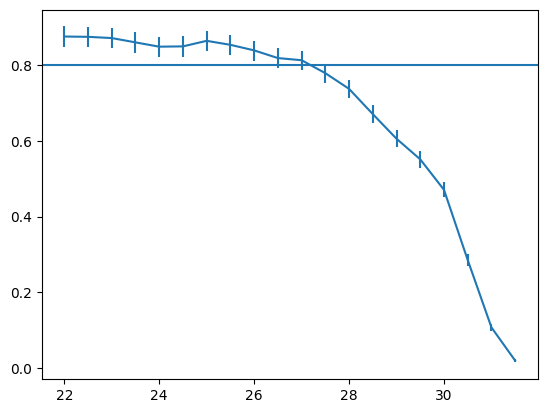

In [21]:
bins=np.arange(start = 21.75, stop = 32.25, step=0.5)
centres = (bins[:-1] + bins[1:]) / 2

up_counts = np.array([arr[0, 1] for arr in error]) - np.array(complete)
lo_counts = np.array(complete) - np.array([arr[0, 0] for arr in error])
error_ = np.row_stack([up_counts, lo_counts])

plt.errorbar(centres, complete, error_)
plt.axhline(0.8)

(22.0, 32.0)

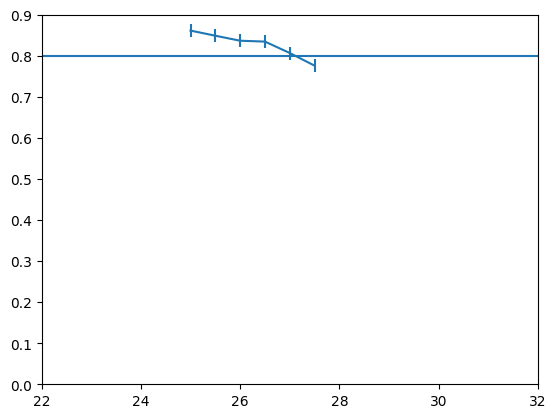

In [8]:
bins=np.arange(start = 24.75, stop = 28.25, step=0.5)
centres = (bins[:-1] + bins[1:]) / 2

up_counts = np.array([arr[0, 1] for arr in error]) - np.array(complete)
lo_counts = np.array(complete) - np.array([arr[0, 0] for arr in error])
error_ = np.row_stack([up_counts, lo_counts])

plt.errorbar(centres, complete, error_)
plt.axhline(0.8)
plt.ylim(0, 0.9)
plt.xlim(22,32)

In [18]:
error

[array([[0.84907771, 0.90296115]]),
 array([[0.84827703, 0.90213582]]),
 array([[0.84507434, 0.89883446]]),
 array([[0.83386568, 0.88727898]]),
 array([[0.82265817, 0.87572235]]),
 array([[0.82345866, 0.87654786]]),
 array([[0.83786864, 0.89140607]]),
 array([[0.82746124, 0.88067533]]),
 array([[0.81305266, 0.86581573]]),
 array([[0.79304403, 0.84517411]]),
 array([[0.78744232, 0.83939375]]),
 array([[0.75383874, 0.80470493]]),
 array([[0.71305066, 0.76256655]]),
 array([[0.64751096, 0.69477356]]),
 array([[0.5836252 , 0.62857876]]),
 array([[0.53016958, 0.57309201]]),
 array([[0.45127981, 0.49100744]]),
 array([[0.2702228 , 0.30133754]]),
 array([[0.09803689, 0.11743953]]),
 array([[0.01557621, 0.02433794]])]

In [20]:
second_elements = [arr[0, 1] for arr in error]
second_elements

[0.9029611475838237,
 0.902135822316731,
 0.8988344639548915,
 0.8872789813514663,
 0.8757223485786818,
 0.8765478609817136,
 0.8914060702775073,
 0.8806753335029895,
 0.8658157303392531,
 0.8451741071805852,
 0.8393937511870281,
 0.8047049265545396,
 0.7625665452932467,
 0.694773561811731,
 0.6285787599321119,
 0.573092006578954,
 0.4910074396681235,
 0.30133753634065596,
 0.11743952792529513,
 0.02433794097792612]

In [14]:
hdr = fits.getheader("/Users/jt458/Desktop/misc/fullceers_ddta_f277w_v1_30mas_sci_bkgsub.fits")

In [15]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                45000                                                  
NAXIS2  =                15400                                                  
EXTEND  =                    T                                                  
EXTNAME = 'SCI     '           / extension name                                 
MJD-BEG =    59751.75679066285 / [d] exposure start time in MJD                 
MJD-AVG =    59851.48926106448 / [d] exposure mid-point in MJD                  
MJD-END =    60027.96578502315 / [d] exposure end time in MJD                   
TDB-BEG =    59751.75638882029 / [d] TDB time of exposure start in MJD          
TDB-MID =    59851.48982240109 / [d] TDB time of exposure mid-point in MJD      
TDB-END =     60027.96315509

In [18]:
hdr['PIXAR_A2']/(60**2)

2.5e-07

In [17]:
(0.03/60)**2


2.5e-07

In [5]:
complete

[0.974390243902439,
 0.9670731707317073,
 0.9634146341463414,
 0.9658536585365853,
 0.9676829268292683,
 0.9664634146341463,
 0.974390243902439,
 0.9597560975609756,
 0.9567073170731707,
 0.9560975609756097,
 0.9469512195121951,
 0.9621951219512195,
 0.9506097560975609,
 0.9457317073170731,
 0.9414634146341463,
 0.9390243902439024,
 0.8908536585365854,
 0.775,
 0.6664634146341464,
 0.6128048780487805,
 0.49878048780487805,
 0.38414634146341464,
 0.17926829268292682,
 0.041463414634146344,
 0.007317073170731708]

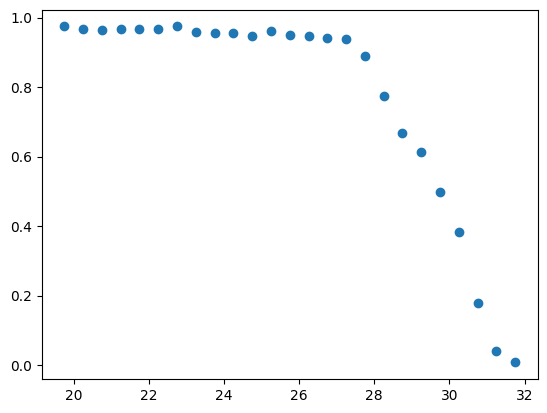

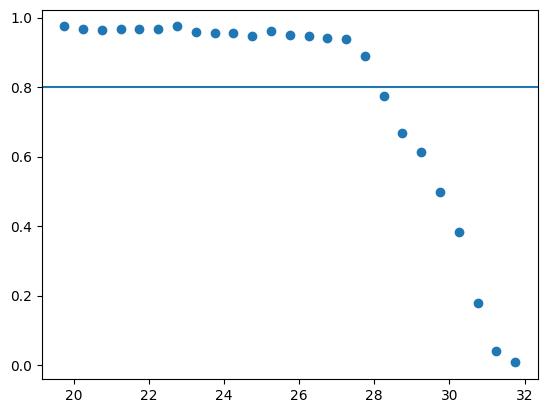

In [ ]:
bins = np.arange(start = 19.75, stop = 32.25, step=0.5)
plt.scatter(bins, complete)
plt.axhline(0.8)